# **Loading Data and Libraries**

In [ ]:
import kagglehub


path = kagglehub.dataset_download("kanchana1990/uae-real-estate-2024-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/kanchana1990/uae-real-estate-2024-dataset/versions/1


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

from scipy.stats import pearsonr, spearmanr, chi2_contingency, ttest_1samp
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

In [ ]:
df = pd.read_csv(path + "/uae_real_estate_2024.csv")
#df = pd.read_csv("uae_real_estate_2024.csv")

In [ ]:
df.head()

,title,displayAddress,bathrooms,bedrooms,addedOn,type,price,verified,priceDuration,sizeMin,furnishing,description
0,Great ROI I High Floor I Creek View,"Binghatti Canal, Business Bay, Dubai",3,2,2024-08-14T12:02:53Z,Residential for Sale,2500000,True,sell,1323 sqft,NO,MNA Properties is delighted to offer this apar...
1,Full Sea View | Beach Life | Brand New Residence,"La Vie, Jumeirah Beach Residence, Dubai",3,2,2024-08-13T05:45:16Z,Residential for Sale,7200000,True,sell,1410 sqft,YES,"Apartment for sale in La Vie, Jumeirah Beach R..."
2,Green Belt | Corner Unit | Spacious Plot,"La Rosa 6, Villanova, Dubai Land, Dubai",3,4,2024-08-14T06:24:28Z,Residential for Sale,3600000,True,sell,2324 sqft,NO,Treo Homes is very pleased to be bringing to t...
3,2BR+Study | Near Pool and Park | Private,"Springs 15, The Springs, Dubai",3,2,2024-08-15T06:07:22Z,Residential for Sale,2999999,True,sell,1647 sqft,NO,2 Bedrooms + Study | Near Pool &amp; Park | Pr...
4,Vacant | Well Maintained | Area Expert,"Noor Townhouses, Town Square, Dubai",3,3,2024-08-09T08:28:59Z,Residential for Sale,2449999,True,sell,2105 sqft,NO,-Type 1\n-3 Bed+Maid\n-Close To Amenities\n-BU...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5058 entries, 0 to 5057
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           5058 non-null   object
 1   displayAddress  5058 non-null   object
 2   bathrooms       4938 non-null   object
 3   bedrooms        4935 non-null   object
 4   addedOn         5058 non-null   object
 5   type            5058 non-null   object
 6   price           5058 non-null   int64 
 7   verified        5058 non-null   bool  
 8   priceDuration   5058 non-null   object
 9   sizeMin         5058 non-null   object
 10  furnishing      5056 non-null   object
 11  description     5057 non-null   object
dtypes: bool(1), int64(1), object(10)
memory usage: 439.7+ KB


In [ ]:
df.describe()

,price
count,5.058000e+03
mean,5.050924e+06
std,1.000928e+07
min,1.000000e+05
25%,1.200000e+06
50%,2.350000e+06
75%,4.499375e+06
max,1.990000e+08


# Preprocessing

In [ ]:
df = df.dropna(subset=['bedrooms', 'bathrooms', 'sizeMin', 'price','furnishing'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4931 entries, 0 to 5057
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           4931 non-null   object
 1   displayAddress  4931 non-null   object
 2   bathrooms       4931 non-null   object
 3   bedrooms        4931 non-null   object
 4   addedOn         4931 non-null   object
 5   type            4931 non-null   object
 6   price           4931 non-null   int64 
 7   verified        4931 non-null   bool  
 8   priceDuration   4931 non-null   object
 9   sizeMin         4931 non-null   object
 10  furnishing      4931 non-null   object
 11  description     4930 non-null   object
dtypes: bool(1), int64(1), object(10)
memory usage: 467.1+ KB


In [ ]:
unique_bedrooms = df['bedrooms'].unique()
print(unique_bedrooms)

['2' '4' '3' '5' '1' 'studio' '7' '6' '7+']


In [ ]:
unique_bedrooms = df['bathrooms'].unique()
print(unique_bedrooms)

['3' '7' '4' '1' '5' '2' '6' '7+' 'none']


In [ ]:
def clean_rooms(value):
    if pd.isna(value):
        return np.nan
    if isinstance(value, str):
        value = value.lower()
        if value in ['studio', 'none']:
            return 0
        value = re.sub(r'\+', '', value)
    return int(value)

df['bedrooms'] = df['bedrooms'].apply(clean_rooms)
df['bathrooms'] = df['bathrooms'].apply(clean_rooms)

In [ ]:
df['city'] = df['displayAddress'].apply(lambda x: str(x).split(',')[-1].strip())
df['community'] = df['displayAddress'].apply(lambda x: x.split(',')[-2].strip() if len(x.split(',')) > 1 else 'Unknown')

In [ ]:
def clean_size(value):
    if pd.isna(value):
        return np.nan

    size = re.findall(r'\d+', str(value).replace(',', ''))
    return int(size[0]) if size else np.nan

df['sizeMin'] = df['sizeMin'].apply(clean_size)

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
selected_features = ['price', 'bedrooms', 'bathrooms', 'sizeMin', 'city','community', 'furnishing']
df = df[selected_features]
df.head()


,price,bedrooms,bathrooms,sizeMin,city,community,furnishing
0,2500000,2,3,1323,Dubai,Business Bay,NO
1,7200000,2,3,1410,Dubai,Jumeirah Beach Residence,YES
2,3600000,4,3,2324,Dubai,Dubai Land,NO
3,2999999,2,3,1647,Dubai,The Springs,NO
4,2449999,3,3,2105,Dubai,Town Square,NO


# Descriptive Statistics

In [ ]:
def descriptive_stats(data, column):
    stats = {
        'Count': data[column].count(),
        'Mean': data[column].mean(),
        'Median': data[column].median(),
        'Std Dev': data[column].std(),
        'Min': data[column].min(),
        '25%': data[column].quantile(0.25),
        '75%': data[column].quantile(0.75),
        'Max': data[column].max()
    }


    stats_df = pd.DataFrame.from_dict(stats, orient='index', columns=['Value'])


    stats_df['Value'] = stats_df['Value'].apply(lambda x: f"{x:,.2f}")

    return stats_df


In [ ]:
# Random sample of 150
sample_random = df.sample(n=150, random_state=42)
descriptive_stats(sample_random, 'price')


,Value
Count,150.00
Mean,"4,785,853.78"
Median,"2,300,000.00"
Std Dev,"10,225,912.37"
Min,"276,000.00"
25%,"1,200,000.00"
75%,"3,998,750.00"
Max,"77,000,000.00"


In [ ]:
# Systematic Sampling
step = len(df) // 150
sample_systematic = df.iloc[::step, :]
descriptive_stats(sample_systematic, 'price')

,Value
Count,155.00
Mean,"4,721,117.21"
Median,"2,600,000.00"
Std Dev,"7,828,896.32"
Min,"360,000.00"
25%,"1,200,000.00"
75%,"4,500,000.00"
Max,"59,000,000.00"


In [ ]:
# Full descriptive statistics for 'price'
full_stats = descriptive_stats(df, 'price')
full_stats

,Value
Count,"4,931.00"
Mean,"4,938,993.96"
Median,"2,350,000.00"
Std Dev,"9,719,464.63"
Min,"100,000.00"
25%,"1,200,000.00"
75%,"4,401,944.00"
Max,"199,000,000.00"


# Visualization

Text(0.5, 1.0, 'Scatter Plot: Price vs Size')

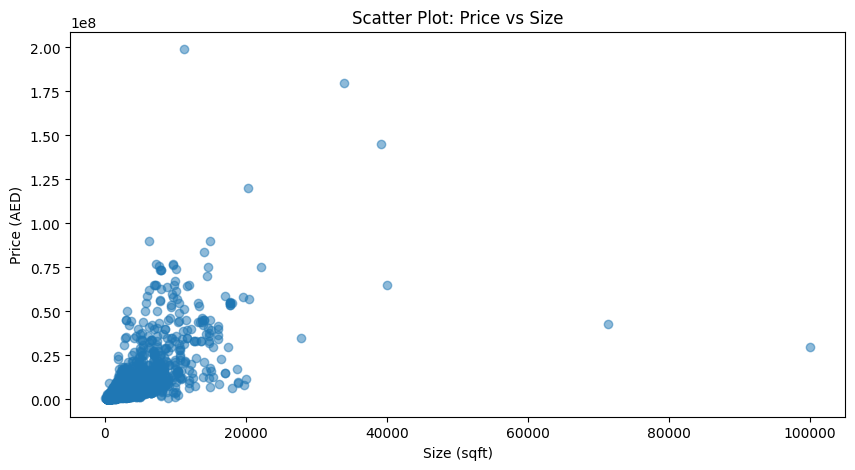

In [ ]:
# Scatter plot: Price vs Size

plt.figure(figsize=(10,5))
plt.scatter(df['sizeMin'], df['price'], alpha=0.5)
plt.xlabel('Size (sqft)')
plt.ylabel('Price (AED)')
plt.title('Scatter Plot: Price vs Size')

Text(0.5, 1.0, 'Box Plot: Price')

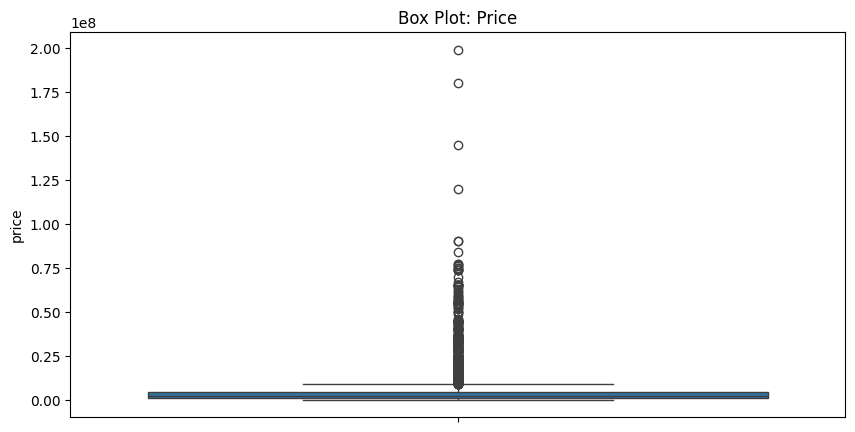

In [ ]:
# Box plot
plt.figure(figsize=(10, 5))
sns.boxplot(y=df['price'])
plt.title('Box Plot: Price')

Text(0, 0.5, 'Frequency')

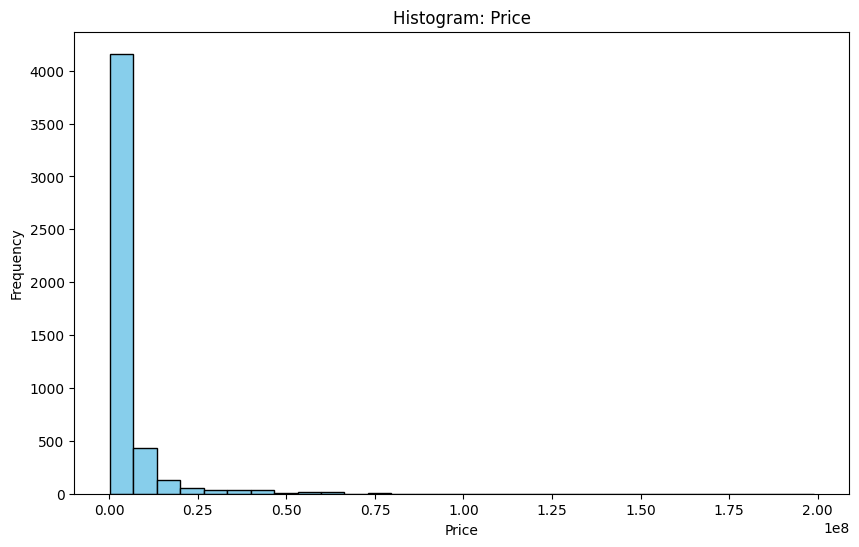

In [ ]:
# Histogram
plt.figure(figsize=(10, 6))
plt.hist(df['price'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram: Price')
plt.xlabel('Price')
plt.ylabel('Frequency')

Text(0.5, 1.0, 'Heat Map: Correlation')

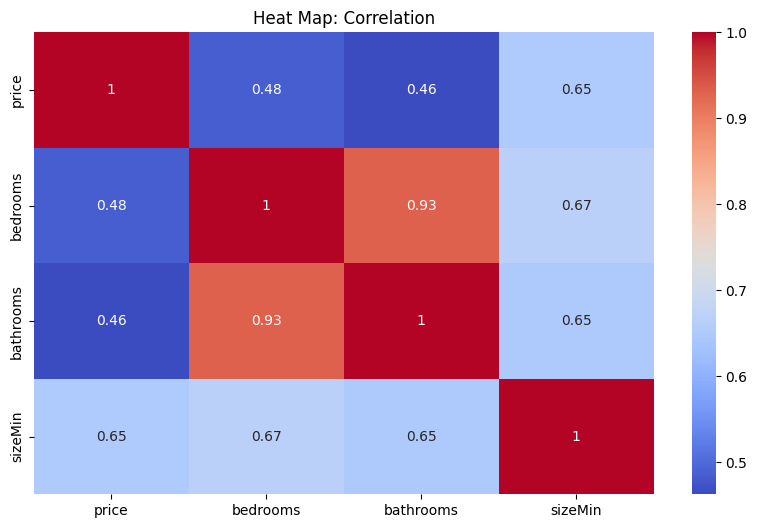

In [ ]:
# Heatmap: Correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(df[['price','bedrooms','bathrooms','sizeMin']].corr(), annot=True, cmap='coolwarm')
plt.title('Heat Map: Correlation')


# Hypothesis Testing

In [ ]:
# Pearson correlation
pearson_corr, pearson_p = pearsonr(df['sizeMin'], df['price'])
print(f"Pearson correlation: {pearson_corr:.2f}, p-value: {pearson_p:.4f}")

# Spearman correlation
spearman_corr, spearman_p = spearmanr(df['sizeMin'], df['price'])
print(f"Spearman correlation: {spearman_corr:.2f}, p-value: {spearman_p:.4f}")

# Chi-square test
df['price_category'] = pd.qcut(df['price'], q=3, labels=['Low', 'Medium', 'High'])

contingency = pd.crosstab(df['city'], df['price_category'])
chi2, chi2_p, dof, expected = chi2_contingency(contingency)

print(f"Chi2 Statistic = {chi2:.2f}")
print(f"Degrees of Freedom = {dof}")
print(f"P-value = {chi2_p:.4f}")

if chi2_p < 0.05:
    print("There is a statistically significant relationship between 'city' and 'price_category'.")
else:
    print("No significant relationship between 'city' and 'price_category'.")

Pearson correlation: 0.65, p-value: 0.0000
Spearman correlation: 0.82, p-value: 0.0000
Chi2 Statistic = 225.10
Degrees of Freedom = 14
P-value = 0.0000
There is a statistically significant relationship between 'city' and 'price_category'.


# One-sample t-test

In [ ]:
population_mean = df['price'].mean()

t_stat, p_val = ttest_1samp(sample_random['price'], population_mean)

print(f"One-sample t-test:")
print(f"  Sample mean = {sample_random['price'].mean():,.2f}")
print(f"  Population mean (full dataset) = {population_mean:,.2f}")
print(f"  t-statistic = {t_stat:.2f}, p-value = {p_val:.4f}")

if p_val > 0.05:
    print("The sample mean is NOT significantly different from the population mean.")
    print("This suggests the random sample is representative of the full dataset.")
else:
    print("The sample mean is significantly different from the population mean.")

One-sample t-test:
  Sample mean = 4,785,853.78
  Population mean (full dataset) = 4,938,993.96
  t-statistic = -0.18, p-value = 0.8547
The sample mean is NOT significantly different from the population mean.
This suggests the random sample is representative of the full dataset.


# Simple Regression

In [ ]:
X_simple = df[['sizeMin']]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X_simple, y, test_size=0.2, random_state=42)

simple_model = LinearRegression()
simple_model.fit(X_train, y_train)

y_pred_simple = simple_model.predict(X_test)


print("Simple Linear Regression Results:")
print(f"R2 Score: {r2_score(y_test, y_pred_simple):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_simple)):.2f}")

Simple Linear Regression Results:
R2 Score: 0.3949
RMSE: 9957331.34


In [ ]:
df = df.drop('price_category', axis=1)

# Multiple Regression

In [ ]:
df_reg = df.copy()
df_reg = pd.get_dummies(df_reg, columns=['city','community','furnishing'], drop_first=True)

X_multi = df_reg.drop('price', axis=1)
y_multi = df_reg['price']

X_train, X_test, y_train, y_test = train_test_split(X_multi, y_multi, test_size=0.2, random_state=42)

multi_model = LinearRegression()
multi_model.fit(X_train, y_train)
y_pred_multi = multi_model.predict(X_test)

print("\nMultiple Linear Regression Results:")
print(f"R2 Score: {r2_score(y_test, y_pred_multi):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_multi)):.2f}")


Multiple Linear Regression Results:
R2 Score: 0.2316
RMSE: 11220645.82


# Classification

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mssmartypants/paris-housing-classification")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/mssmartypants/paris-housing-classification/versions/4


In [ ]:
df = pd.read_csv(path + "/ParisHousingClass.csv")
#df = pd.read_csv("ParisHousingClass.csv")

In [ ]:
df.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,category
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5,Basic
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5,Luxury
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1,Basic
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2,Basic
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0,Luxury


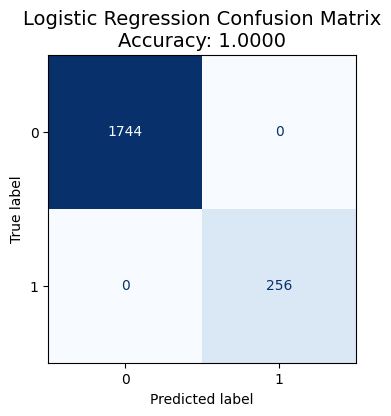

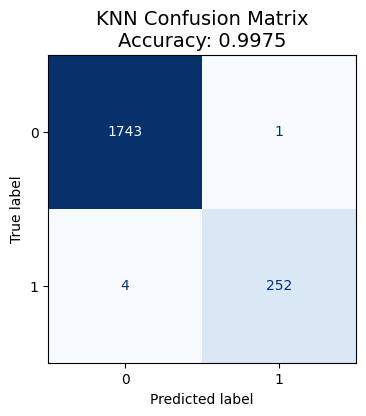

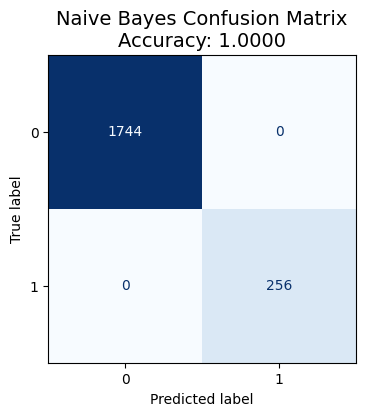

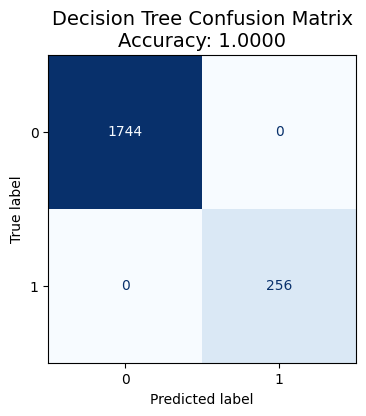

In [ ]:
X_class = df.drop(['price','category'], axis=1)
y_class = df['category']

le = LabelEncoder()
y_class_encoded = le.fit_transform(y_class)

X_train, X_test, y_train, y_test = train_test_split(X_class, y_class_encoded, test_size=0.2, random_state=42)



scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build models
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000),
    "KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=1),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

    results[name] = {'Accuracy': acc, 'ConfusionMatrix': cm, 'Model': model}

    # Display confusion matrix
    fig, ax = plt.subplots(figsize=(4,4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)  # use ax to control size
    plt.title(f'{name} Confusion Matrix\nAccuracy: {acc:.4f}', fontsize=14)
    plt.show()

In [ ]:
best_classifier_name = max(results, key=lambda x: results[x]['Accuracy'])
print(f"\nBest-fit Classifier: {best_classifier_name}")

best_model = models[best_classifier_name]
y_best_pred = best_model.predict(X_test)


Best-fit Classifier: Logistic Regression


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


# Clustering

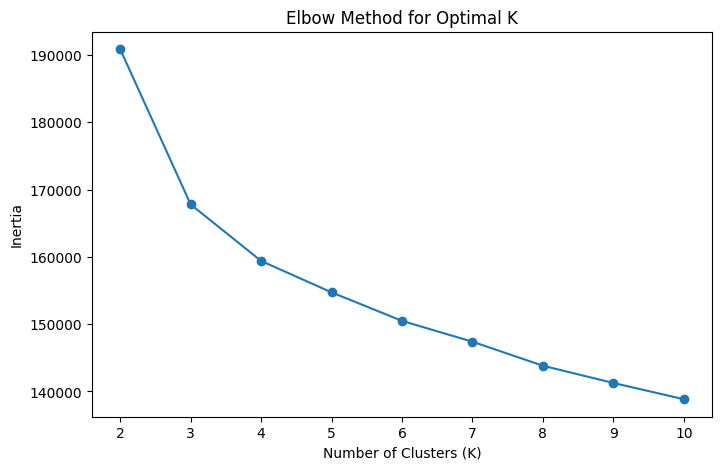

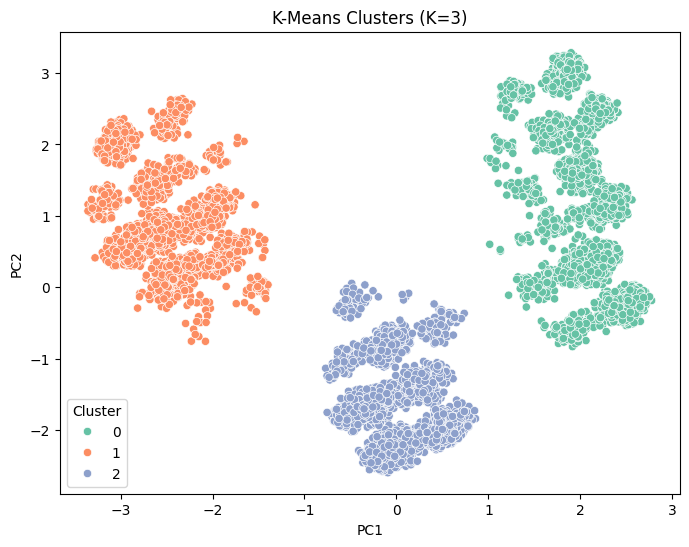


K-Means Cluster Summary (Mean Values):
                squareMeters  numberOfRooms   hasYard   hasPool     floors  \
KMeans_Cluster                                                               
0               51183.023706      48.716103  0.417462  0.522405  50.685169   
1               48257.729700      51.710935  0.538434  0.841573  51.835438   
2               49850.680106      50.871088  0.570557  0.219894  48.755172   

                    cityCode  cityPartRange  numPrevOwners         made  \
KMeans_Cluster                                                            
0               47235.054351       5.452443       5.692686  2005.471234   
1               51578.100686       5.701552       5.340671  2005.093107   
2               51975.037401       5.422281       5.497878  2005.794960   

                isNewBuilt  ...      garage  hasStorageRoom  hasGuestRoom  \
KMeans_Cluster              ...                                             
0                 0.699335  ...  551.65

In [ ]:
X_cluster = df.drop(['price', 'category'], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

inertia = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['KMeans_Cluster'], palette='Set2')
plt.title(f'K-Means Clusters (K={optimal_k})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.show()


print("\nK-Means Cluster Summary (Mean Values):")
print(df.groupby('KMeans_Cluster').mean(numeric_only=True))

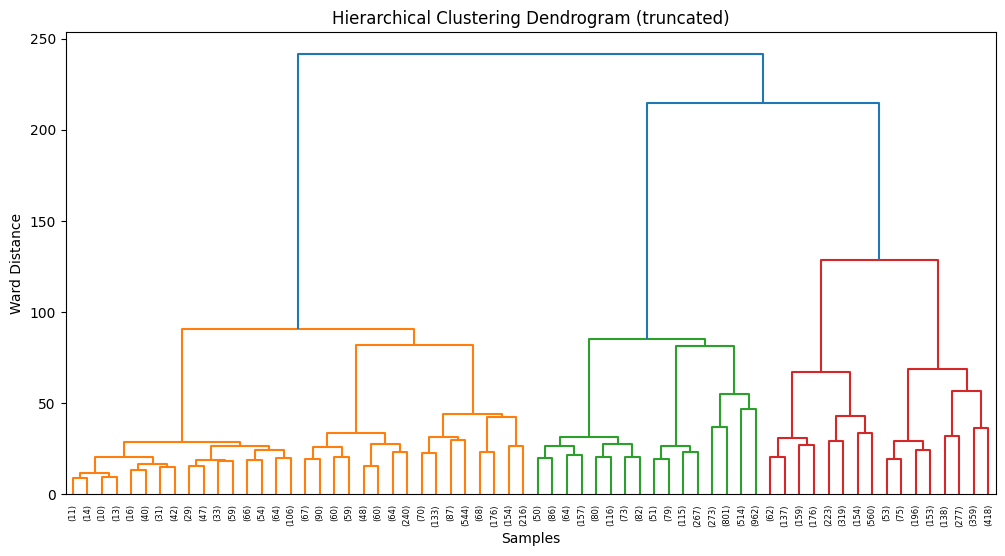


Agglomerative Clustering Silhouette Score (n_clusters=3): 0.1546


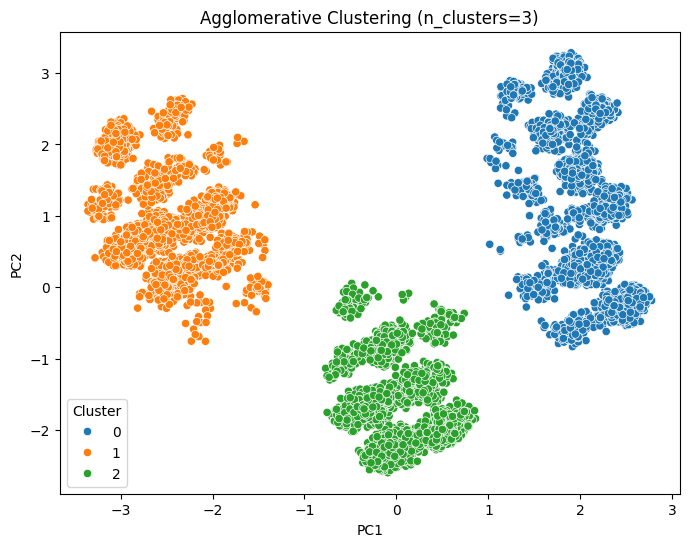


Hierarchical Cluster Summary (Mean Values):
             squareMeters  numberOfRooms   hasYard   hasPool     floors  \
HierCluster                                                               
0            51183.023706      48.716103  0.417462  0.522405  50.685169   
1            48257.729700      51.710935  0.538434  0.841573  51.835438   
2            49850.680106      50.871088  0.570557  0.219894  48.755172   

                 cityCode  cityPartRange  numPrevOwners         made  \
HierCluster                                                            
0            47235.054351       5.452443       5.692686  2005.471234   
1            51578.100686       5.701552       5.340671  2005.093107   
2            51975.037401       5.422281       5.497878  2005.794960   

             isNewBuilt  ...      garage  hasStorageRoom  hasGuestRoom  \
HierCluster              ...                                             
0              0.699335  ...  551.654814        0.483088      5.070541

In [ ]:
plt.figure(figsize=(12, 6))
Z = linkage(X_scaled, method='ward')
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Samples')
plt.ylabel('Ward Distance')
plt.show()

n_clusters_hier = 3
agg = AgglomerativeClustering(n_clusters=n_clusters_hier, linkage='ward')
df['HierCluster'] = agg.fit_predict(X_scaled)

sil_score = silhouette_score(X_scaled, df['HierCluster'])
print(f"\nAgglomerative Clustering Silhouette Score (n_clusters={n_clusters_hier}): {sil_score:.4f}")

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['HierCluster'], palette='tab10')
plt.title(f'Agglomerative Clustering (n_clusters={n_clusters_hier})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.show()

print("\nHierarchical Cluster Summary (Mean Values):")
print(df.groupby('HierCluster').mean(numeric_only=True))